In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [2]:
#Importing necessary libraries
import sklearn.metrics as metrics
import datetime
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from requests import get
import math
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
#To display all the columns and rows
pd.set_option('display.max_columns', 1000);
pd.set_option('display.max_rows', 1000);
pd.set_option('display.width', 1000);
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
#Reading the data file
df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Independent_Study/Depression_Study/preprocessed_depression_study.csv")
#Creating a copy
df_copy = df

In [5]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 76 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Y1IL6                   984 non-null    float64
 1   Y1CRP                   984 non-null    float64
 2   Y1TNFa                  984 non-null    float64
 3   Y1MCP1                  984 non-null    float64
 4   Y1PTX3                  985 non-null    float64
 5   osteopontin             984 non-null    float64
 6   ngal                    984 non-null    float64
 7   ngalplasmaspecific      984 non-null    float64
 8   st2                     984 non-null    float64
 9   galectin3               984 non-null    float64
 10  gdf15                   984 non-null    float64
 11  Y1Leptin                984 non-null    float64
 12  Y1Insulin               983 non-null    float64
 13  Y1microalb_creat_ratio  926 non-null    float64
 14  Y1ALBUM                 1021 non-null   

Checking class imbalance for all the output features

In [6]:
# List of target columns
targets = ['Y1MED1FF', 'PHQ', 'Y1DPCURR', 'Y1DPYEAR']

for col in targets:
    print(f"Class distribution for {col}:")
    counts = df[col].value_counts(dropna=False)
    percent = df[col].value_counts(normalize=True, dropna=False) * 100
    class_dist = pd.DataFrame({'Count': counts, 'Percent': percent.round(2)})
    print(class_dist)
    print("-"*40)


Class distribution for Y1MED1FF:
          Count  Percent
Y1MED1FF                
0.000       668   65.300
1.000       304   29.720
9.000        49    4.790
NaN           2    0.200
----------------------------------------
Class distribution for PHQ:
       Count  Percent
PHQ                  
0.000    825   80.650
1.000    198   19.350
----------------------------------------
Class distribution for Y1DPCURR:
          Count  Percent
Y1DPCURR                
0           793   77.520
1           230   22.480
----------------------------------------
Class distribution for Y1DPYEAR:
          Count  Percent
Y1DPYEAR                
0           562   54.940
1           461   45.060
----------------------------------------


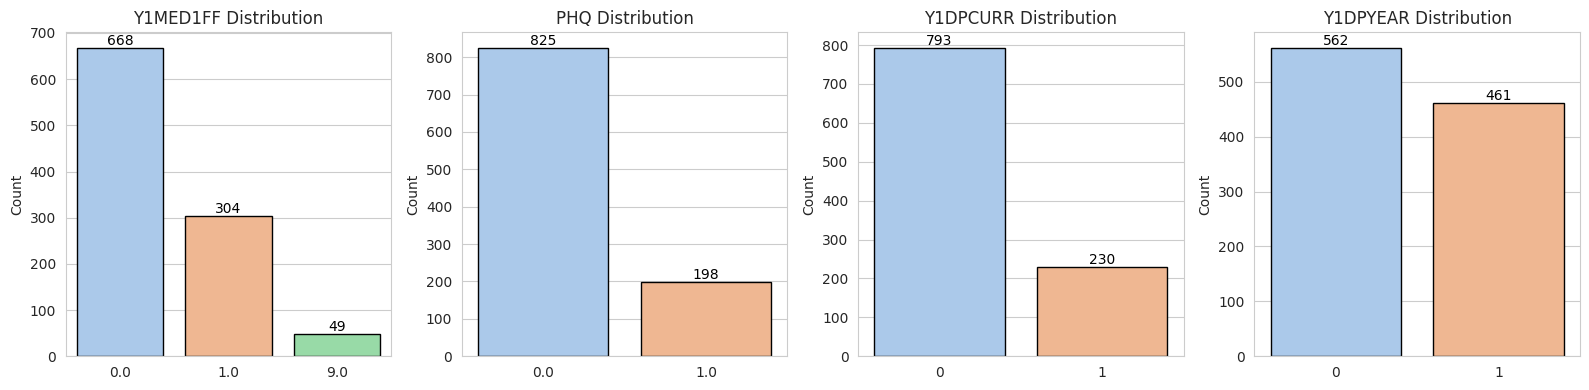

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

targets = ['Y1MED1FF', 'PHQ', 'Y1DPCURR', 'Y1DPYEAR']

plt.figure(figsize=(16,4))
sns.set_style("whitegrid")  # clean background

for i, col in enumerate(targets, 1):
    ax = plt.subplot(1, 4, i)
    sns.countplot(x=col, data=df, palette='pastel', edgecolor='black')

    # Add counts on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black')

    ax.set_title(f'{col} Distribution', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

We have 4 output features.

1. If the output feature is Y1MEDIFF then we are removing 9, and NaN values while running the model.

2. Other output features don't have 9 value so we are just proceeding as it is with all the data.

In [9]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
import pandas as pd

# List of target columns
targets = ['Y1MED1FF', 'PHQ', 'Y1DPCURR', 'Y1DPYEAR']

# Dictionary to store results
catboost_results = {}
catboost_models = {}

for target in targets:
    print(f"Running CatBoost for {target}...\n")

    # Drop other target columns
    other_targets = [col for col in targets if col != target]
    df_target = df.drop(columns=other_targets)

    # Drop ambiguous/missing target values
    if target == 'Y1MED1FF':
        df_target = df_target[df_target[target].isin([0,1])]
    else:
        df_target = df_target.dropna(subset=[target])

    # Features and target
    X = df_target.drop(columns=[target])
    y = df_target[target]

    # Train/test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Compute class weights
    counts = y_train.value_counts()
    class_weights = [counts[0]/counts[1] if 1 in counts else 1, 1]  # weight for 0 and 1

    # Initialize CatBoostClassifier
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        class_weights=class_weights,
        random_seed=42,
        verbose=0
    )

    # Fit model
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    catboost_models[target] = model

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_curve, precision_curve)

    # Store results
    catboost_results[target] = {
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }

# Display results
results_df = pd.DataFrame(catboost_results).T
print(results_df)


Running CatBoost for Y1MED1FF...

Running CatBoost for PHQ...



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running CatBoost for Y1DPCURR...



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running CatBoost for Y1DPYEAR...

             TP     FP      TN     FN  Accuracy  Precision  Recall  Specificity  F1 Score   FPR  ROC AUC  PR AUC
Y1MED1FF 18.000  6.000 128.000 43.000     0.749      0.750   0.295        0.955     0.424 0.045    0.721   0.575
PHQ       0.000  0.000 165.000 40.000     0.805      0.000   0.000        1.000     0.000 0.000    0.778   0.390
Y1DPCURR  0.000  0.000 159.000 46.000     0.776      0.000   0.000        1.000     0.000 0.000    0.616   0.282
Y1DPYEAR 33.000 26.000  87.000 59.000     0.585      0.559   0.359        0.770     0.437 0.230    0.618   0.556


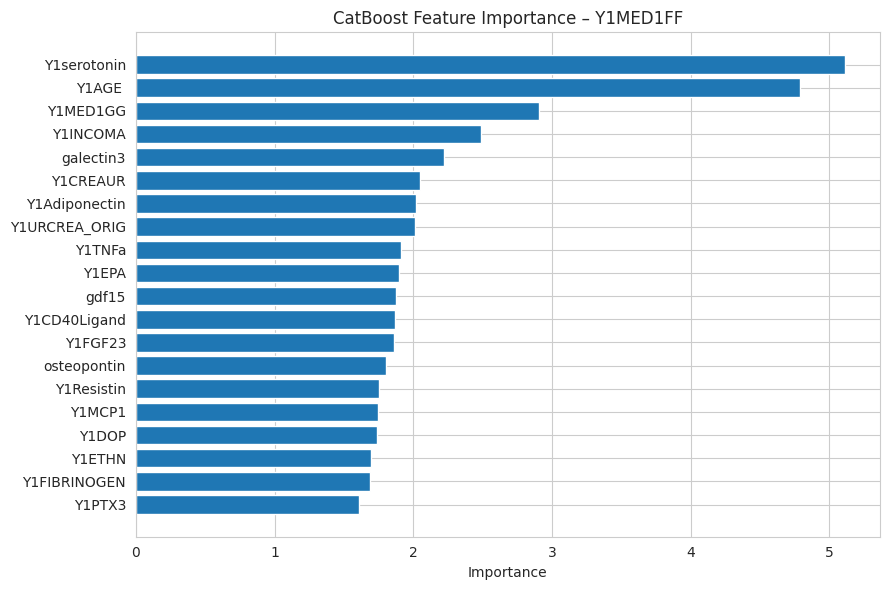

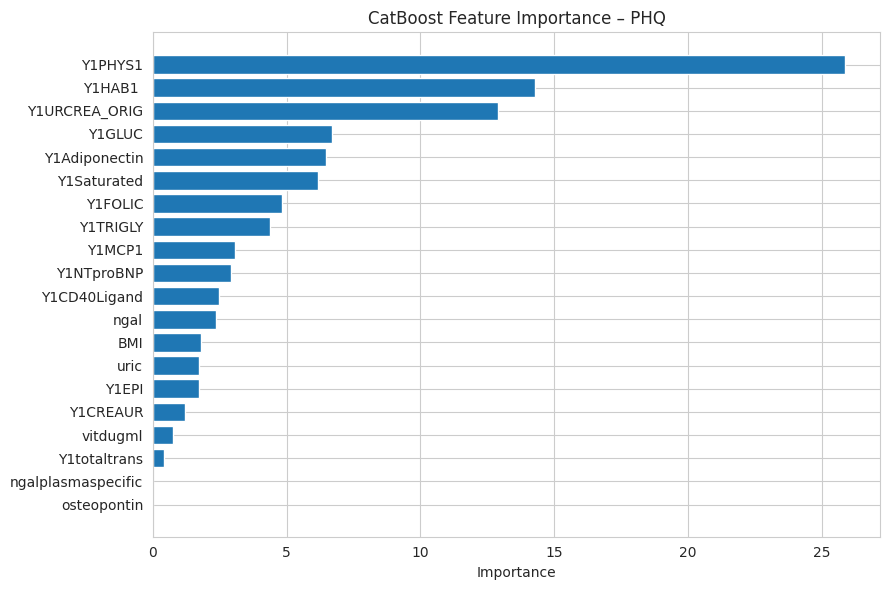

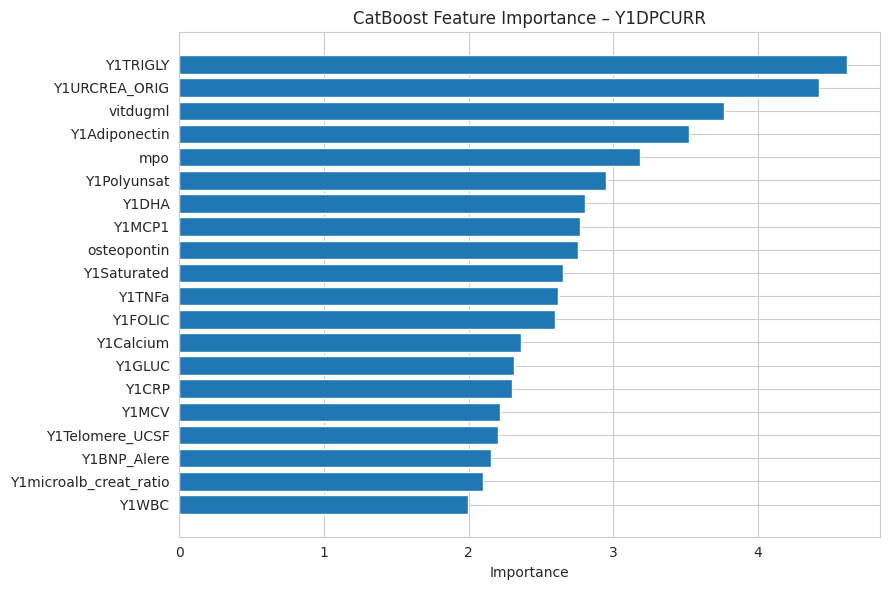

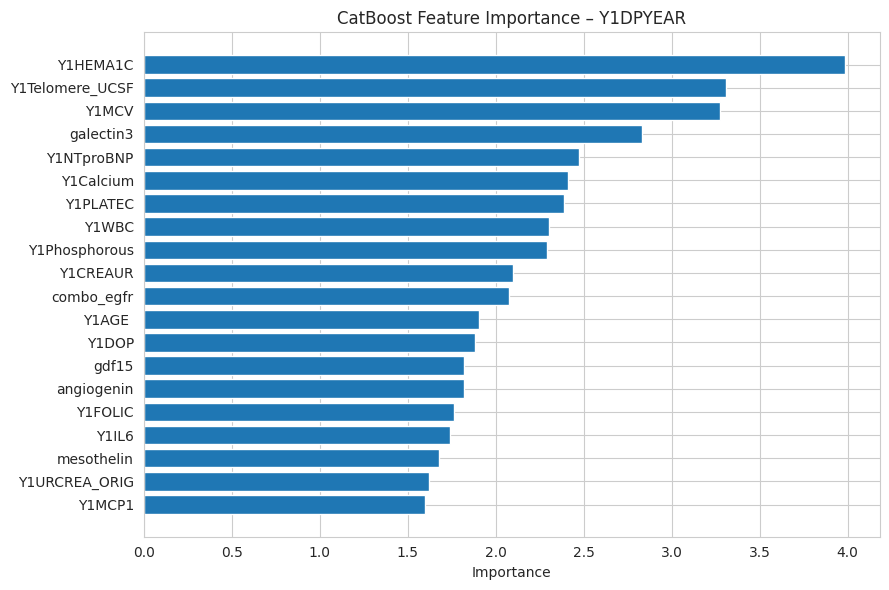

In [10]:
for target, model in catboost_models.items():

    importances = model.get_feature_importance(type='PredictionValuesChange')
    features = model.feature_names_

    fi_df = (
        pd.DataFrame({'Feature': features, 'Importance': importances})
        .sort_values(by='Importance', ascending=False)
        .head(20)
    )

    plt.figure(figsize=(9,6))
    plt.barh(fi_df['Feature'][::-1], fi_df['Importance'][::-1])
    plt.xlabel('Importance')
    plt.title(f'CatBoost Feature Importance – {target}')
    plt.tight_layout()
    plt.show()
